# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [18]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [19]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

In [20]:
def draw(X, Y, THETA):
    plt.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    plt.show()

In [21]:
#Helper functions for g2o
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (jnp.array( ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def write_poses(poses,file_name):
    with open(file_name, 'w') as f:
        for i in range(poses.shape[0]):
            st = "VERTEX_SE2 " + str(i) + " " + str(poses[i][0]) + " " + str(poses[i][1]) + " " + str(poses[i][2])
            f.write("%s\n" % st)
        
        # write edges and FIX
        f2 = open('../data/edges.txt', 'r')
        A = f2.readlines()
        f2.close()
        
        for line in A:
            if "VERTEX_SE2" not in line:
                f.write("%s" % line)

Initial trajectory:


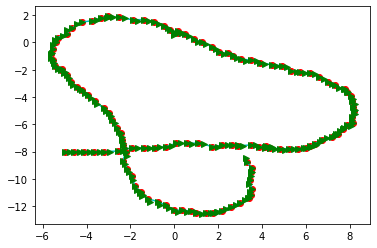

In [22]:
#Reading the given data
vertex = readVertex('../data/edges.txt')
edges = readEdge('../data/edges.txt')
x = vertex[0][0]
y = vertex[1][0]
theta = vertex[2][0]
poses = []
initial_pose = jnp.array([x, y, theta])
anchor = initial_pose
poses.append(initial_pose)
for k in range(len(edges[0])):
    i = edges[0][k]
    j = edges[1][k]
    deltax = edges[2][k]
    deltay = edges[3][k]
    deltatheta = edges[4][k]
    if(abs(j-i) == 1):
        x_next = x + deltax * jnp.cos(theta) - deltay * jnp.sin(theta)
        y_next = y + deltay * jnp.cos(theta) + deltax * jnp.sin(theta)
        theta_next = theta + deltatheta
        x = x_next
        y = y_next
        theta = theta_next
        next_pose = jnp.array([x, y, theta])
        poses.append(next_pose)
poses = jnp.array(poses)
x_arr = jnp.array(poses[:, 0])
y_arr = jnp.array(poses[:, 1])
theta_arr = jnp.array(poses[:, 2])
print("Initial trajectory:")
draw(x_arr, y_arr, theta_arr)
write_poses(poses, 'edges-poses.g2o')

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [23]:
#Hyperparameters
info_odom = 10
info_loopclosure = 1000
info_anchor = 1200
best_index = 0
num_of_iters = 60
lr = 1

In [24]:
gt_poses = readVertex('../data/gt.txt')
gt_poses = gt_poses.T

In [25]:
def draw3(X, Y, THETA, Xin, Yin, THETAin, Xg, Yg, THETAg):
    ax = plt.subplot(111)
    ax.plot(Xin, Yin, 'ro')
    ax.plot(Xin, Yin, 'c-')
    
    x2 = 0.25*math.cos(THETAin[0]) + Xin[0]
    y2 = 0.25*math.sin(THETAin[0]) + Yin[0]
    plt.plot([Xin[0], x2], [Yin[0], y2], 'g->', label = "Initial trajectory")

    for i in range(1, len(THETAin)):
        x2 = 0.25*math.cos(THETAin[i]) + Xin[i]
        y2 = 0.25*math.sin(THETAin[i]) + Yin[i]
        plt.plot([Xin[i], x2], [Yin[i], y2], 'g->')
    
    ax.plot(Xg, Yg, 'ro')
    ax.plot(Xg, Yg, 'c-')
        
    x2 = 0.25*math.cos(THETAg[0]) + Xg[0]
    y2 = 0.25*math.sin(THETAg[0]) + Yg[0]
    plt.plot([Xg[0], x2], [Yg[0], y2], 'r->', label = "Ground truth")

    for i in range(1, len(THETAg)):
        x2 = 0.25*math.cos(THETAg[i]) + Xg[i]
        y2 = 0.25*math.sin(THETAg[i]) + Yg[i]
        plt.plot([Xg[i], x2], [Yg[i], y2], 'r->')
    
    ax.plot(X, Y, 'ro')
    ax.plot(X, Y, 'c-')
    
    x2 = 0.25*math.cos(THETA[0]) + X[0]
    y2 = 0.25*math.sin(THETA[0]) + Y[0]
    plt.plot([X[0], x2], [Y[0], y2], 'b->', label = "Current trajectory")

    for i in range(1, len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'b->')
    
    plt.legend()
    plt.show()

In [26]:
def getInfoMatrix(edges, info_odom, info_loopclosure, info_anchor):
    mat = []
    for l in range(3):
        mat.append(info_anchor)
    for k in range(len(edges[0])):
        i = edges[0][k]
        j = edges[1][k]
        if abs(j - i) == 1:
            for l in range(3):
                mat.append(info_odom)
        else:
            for l in range(3):
                mat.append(info_loopclosure)
    
    return jnp.diag(jnp.asarray(mat))

In [27]:
def getError(traj, edges, anchor, omega):
    f = getResidual(traj, edges, anchor)
    return f.T@omega@f

In [28]:
def getResidual(traj, edges, anchor):
    residual = []
    residual.extend(list(traj[0] - anchor))
    for k in range(len(edges[0])):
        i = edges[0][k]
        j = edges[1][k]
        
        x = traj[i][0]
        y = traj[i][1]
        theta = traj[i][2]
        
        deltax = edges[2][k]
        deltay = edges[3][k]
        deltatheta = edges[4][k]
        x_next = x + deltax * jnp.cos(theta) - deltay * jnp.sin(theta)
        y_next = y + deltay * jnp.cos(theta) + deltax * jnp.sin(theta)
        theta_next = theta + deltatheta
        traj_next = jnp.asarray([x_next, y_next, theta_next])
        residual.extend(list(traj_next - traj[j]))
    return jnp.asarray(residual)

In [29]:
def getDerivative(deltax, deltay, theta):
    ret = jnp.eye(3)
    ret = ret.at[jax.ops.index[0, 2]].set(- deltax * jnp.sin(theta) - deltay * jnp.cos(theta))    
    ret = ret.at[jax.ops.index[1, 2]].set(- deltay * jnp.sin(theta) + deltax * jnp.cos(theta))
    return ret

In [30]:
def getJacobian(poses, edges):
    rows = (len(edges[0]) * 3) + 3
    cols = poses.shape[0] * 3
    
    J = jnp.zeros((rows, cols))
    
    #anchor edges
    J = J.at[jax.ops.index[:3, :3]].set(jnp.eye(3))
    
    #all other edges
    for k in range(len(edges[0])):
        i = edges[0][k]
        j = edges[1][k]
        deltax = edges[2][k]
        deltay = edges[3][k]
        deltatheta = edges[4][k]
        
        J = J.at[jax.ops.index[3 + k*3:3 + k*3 + 3, i*3: i*3 + 3]].set(getDerivative(deltax, deltay, poses[i][2]))
        I = -1*jnp.eye(3)
        J = J.at[jax.ops.index[3 + k*3:3 + k*3 + 3, j*3: j*3 + 3]].set(I)
    
    return J

In [31]:
print(getResidual(poses, edges, anchor).shape)

(420,)


### Comparing Jacobians

Frobenius norm between mat1 and mat2 is: 0.0


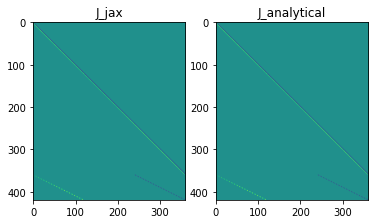

(420, 360)


In [32]:
J_analytical = getJacobian(poses, edges)
J_jax = jax.jacfwd(getResidual)(poses, edges, anchor).reshape((420, -1, 1))[:, :, 0]
frobNorm(J_analytical, J_jax)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(J_jax)
ax[0].set_title('J_jax')
ax[1].imshow(J_analytical)
ax[1].set_title('J_analytical')
plt.show()

print(J_analytical.shape)

Iteration: 10, Error: 96.06364
Current trajectory:


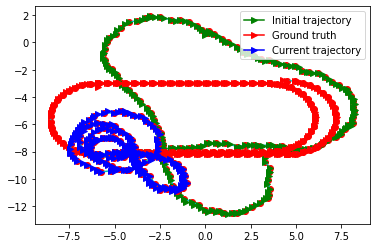

Iteration: 20, Error: 39.78697
Current trajectory:


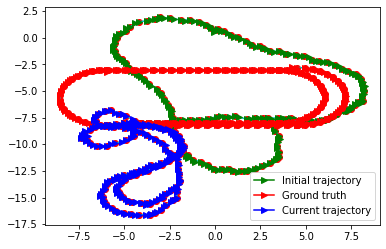

Iteration: 30, Error: 28.14879
Current trajectory:


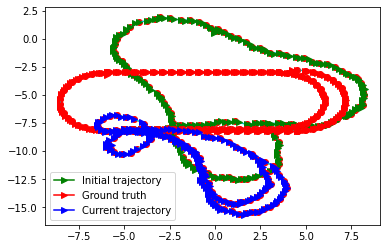

Iteration: 40, Error: 21.829153
Current trajectory:


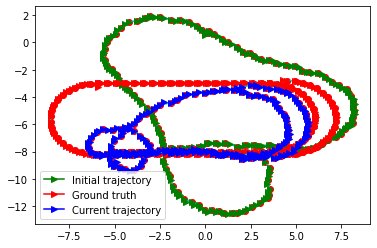

Iteration: 50, Error: 19.345648
Current trajectory:


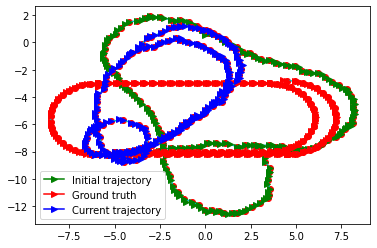

Iteration: 60, Error: 19.32972
Current trajectory:


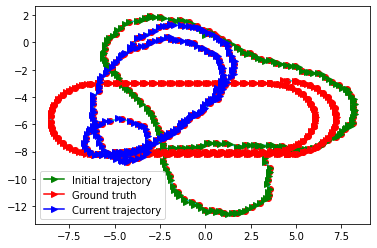

In [33]:
info_mat = getInfoMatrix(edges, info_odom, info_loopclosure, info_anchor)
initial_traj = poses
residual = getResidual(initial_traj, edges, anchor)
error = getError(initial_traj, edges, anchor, info_mat)
prev_error = error
best_error = error
traj = initial_traj
all_trajs = [traj]
for i in range(num_of_iters):
    residual = getResidual(traj, edges, anchor)
    J = jax.jacfwd(getResidual)(traj, edges, anchor).reshape((420, -1, 1))[:, :, 0]
    H = J.T@info_mat@J + lr*jnp.eye(360)
    b = J.T@info_mat.T@residual
    delta = - jnp.linalg.inv(H)@b
    delta = delta.reshape(120, 3)
    traj_next = traj + delta
    error = getError(traj_next, edges, anchor, info_mat)
    if i != 0:
        if error > prev_error:
            lr = lr * 2
        else:
            lr = lr / 2
    traj = traj_next
    prev_error = error
    if error < best_error:
        best_error = error
        index = i
    all_trajs.append(traj)
    if (i + 1) % 10 == 0:
        print("Iteration: " + str(i+1) + ", Error: " + str(error))
        print("Current trajectory:")
        draw3(traj[:, 0], traj[:, 1], traj[:, 2], x_arr, y_arr, theta_arr, gt_poses[:, 0], gt_poses[:, 1], gt_poses[:, 2])

## g2o Visualization

![title](estimate.png)

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Residual

The minimization terms for anchor, odometry and loop closure constraints are used. The anchor constraint 'anchors' a point to a fixed position. Consider an edge between `i` and `j`. We estimate


$$x_{j} = x_{i} + \Delta x_{i, j} \cos (\theta_{i}) - \Delta y_{i, j} \sin(\theta_{i})$$


$$y_{j} = y_{i} + \Delta y_{i, j} \cos(\theta_{i}) + \Delta x_{i, j} \sin (\theta_{i})$$


$$\theta_{j} = \theta_{i} + \Delta \theta_{i}$$


and find the difference between this estimated pose and actual pose `j`. These are appended to the array. For odometric constraints, `j = i + 1`, but for loop closure constraints that may not be true. The residual has shape $(420, )$. This is $3 \times $ (number of vertices $+$ number of loop closure edges).

## Jacobian

The Jacobian has number of rows = $3 \times $ (number of vertices $+$ number of loop closure edges) and number of columns =  $3 \times $ (number of vertices).


Here, number of vertices $= 120$, number of loop closure edges $= 20$. 


Therefore, the Jacobian has shape $(420, 360)$.

## Optimization process and observations

The process of optimization is seen to vary greatly with changes in hyperparameters and intial estimates. The initial trajectory being fixed, we tried different values of damping factors and information values (present in the information matrix). The effect of the information values present was much more significant, and we kept the damping factor fixed as 1. On experimenting with different values of information, we see that

1. The given values of 100, 500 and 700 produced an error of about 889.15 in 34 iterations, which is rather high.
2. Values taken as 50, 1500 and 2000 produced an error of about 96.26 in 54 iterations, which is still above the threshold of 40 as mentioned.
3. Values taken as 10, 1000, 1200 produced an error of about 19.33 in 60 iterations.

We thus obtained a minimum error of 19.33 as calculated by the given method. The trajectory obtained is not the same as the actual trajectory since it seems tilted instead of horizontal, but to a great extent has achieved an oval shape as expected. We can also see that towards the end, the optimised trajectory curves anticlockwise along the same oval which is also seen in the actual trajectory.

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [45]:
write_poses(all_trajs[index], "estimate.g2o")